# Localization with a known map &mdash; Part 1 <br/> Key Components of the Model
<!-- Key Components of the Model -->
<!-- Introduction to Localization with Known Map: Modeling and Key Components -->

Throughout this tutorial, we aim to equip you with the knowledge and practical insights required to tackle the challenges of SLAM and effectively localize a robot in complex environments.
    
In this series of tutorials, we explore a simplified version of the SLAM problem: *Localization using a known map*. Here the map is represented as a collection of line segments. Furthermore, we will explore an optional feature that allows the environment to be cluttered with additional boxes that are not included in the map, creating what we refer to as an "idealized" map.

To begin, we will break down the localization model into its key components: 

- The pose prior, which provides an initial estimate of the robot's position. 
- The control prior, which characterizes the intended motion of the robot.  
- The motion model, which describes how the robot's position evolves over time based on its past position and the control. 
- Lastly, we will delve into the sensor model, which enables the robot to perceive its surroundings.

The sensor model will be presented in two versions. 
- First, we will introduce a "plug-and-play" approach utilizing Gen distributions, as well as Gen's Mixture and Product Distribution types, offering flexibility and ease of implementation. 
- Subsequently, we will showcase a performance-optimized version that employs a custom Gen distribution, maximizing performance.
- In addition to the two presented versions, there is a third version of the sensor model that explicitly models the presence of outliers in the data. This version goes beyond the implicit treatment of outliers in the previous models. 

For the third version, we show how an outlier map can be extracted (using Gen's `update` and `project` methods), allowing for the classification of each observation data point as either an outlier or an inlier. This explicit outlier modeling enables more precise inference and analysis.

...

**Lessons** 

OVERVIEW DRAFT

- The probabilistic graphical model for SLAM, and how to model its key components &mdash; the full model will be introduced in Part 2.
- Example of Gen's `HomogenousMixture` and `HeterogeneousMixture` type, Gen's `Map` combinator, my Gen `Product` type.
- Getting introduced to the *2dp3 likelihood* (using our own `cast` and `get_2d_mixture_components` methods to implemennt it; these methods are defined in a different notebook actually), and Gen's *Distribution API* to write a custom sensor distributions.
- Explicitly modeling observation outliers and how to use Gen's `update` and `project` mehtods to classify observation outliers.


**Notation and naming conventions** 

I usually try to keep variable naming concise and closer to the conventions found in mathematical papers, rather than those used in software engineering. I find that adopting this approach makes it easier to comprehend research code. However, it is essential to provide additional notes or documentation to provide context for interpreting variable names.

```julia
    x              = rand(2)  # Preferred
    agent_position = rand(2)  # Sometimes OK as well

    ỹ = sliding_windows(y, 10, 1)                      # Preferred
    sliding_windows_over_y = sliding_windows(y, 10, 1) # Hard to parse
    
```

In line with this practice, I make an effort to indicate CUDA arrays by appending a trailing underscore. For example, if we have an array `x`, its CUDA version would be denoted as `x_`:

```julia
    x  = rand(100,100)
    x_ = CuArray(x)
```

Following a Python-inspired convention, I use leading underscores for contants or varibales that are not supposed to change. This allows me to reuse descriptive names without conflicting with constant values. Consequently, I can employ these informative names directly in the code that follows, ensuring clarity and readability.

```julia
    ps = [ p+u for (p, u) in zip(_ps, _us) ]
```

In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
#nbx --fname="src/localization_part_1.jl"
push!(LOAD_PATH, "../src");
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using BenchmarkTools;
using CUDA
using LaTeXStrings
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt: @f_str, format # Python-style f-strings
using MyUtils
using MyCudaUtils
using StatsBase: mean
using Random: shuffle, randperm
using Geometry: Segment
include("../src/pose.jl");
include("src/plotting.jl");

using GenDistributionZoo: ProductDistribution, diagnormal
mvuniform = ProductDistribution(uniform);

We included a bunch of stuff there including: a few useful type, e.g. `Pose(x,hd)`, `Control(dx, dhd)`, and `Segment(x,x′,y,y′)`, and plenty of convenient methods to process and work with them.




## The Localization Task and its Inputs: 

The agent's objective is to accurately locate itself on an approximate map using the following inputs:
- An idealized map (`_segs`), provided below.
- A perturbed version of the controls (`_us_noisy`), generated below.
- Observations (`_zs` and `_as`; or the Euclidean version `_ys`), also generated below. These observations are made in a cluttered environment with additional boxes (`_boxes`), included below.

By running the subsequent cells below, we include various variables such as ground truth poses (`_ps`), ground truth controls (`_us`), environment line segments (`_segs`), and boxes (`_boxes`). We then create observations in the cluttered environment and generate a noisy version of the controls as input for the task.

### Load environment and path data

In [3]:
#nbx
# Load the environment and 
# ground truth poses and 
# set the bounding box
include("src/house_expo_data.jl");
_bb = bounding_box(_segs);

Loading data from `../data/task_inputs/example_1.json`, and
populating Main namespace with variables:



_segs      Vector{Segment}
_boxes     Vector{Segment}
_center    Vector{Float64}
_xs        Vector{Vector{Float64}}
_hds       Vector{Float64}
_ps        Vector{Pose}
_dxs       Vector{Vector{Float64}}
_dhds      Vector{Float64}
_us        Vector{Control}
_T         Int64


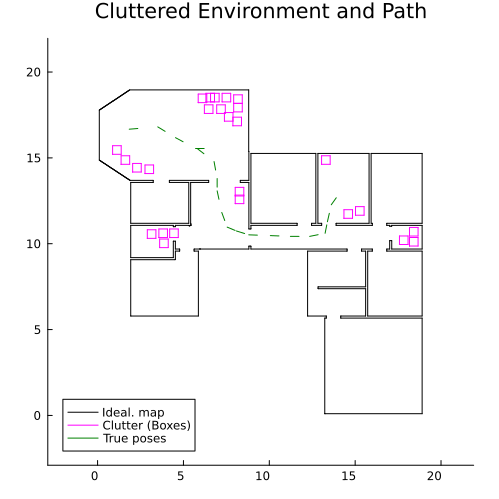

In [4]:
# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Cluttered Environment and Path", grid=false,
xlim=(_bb[1][1]-3, _bb[2][1]+3),
ylim=(_bb[1][2]-3, _bb[2][2]+3),
legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(_ps[[1]], c=:green, linewidth=1, label="True poses")
plot!(_ps[2:end], c=:green, linewidth=1, label=nothing)
savefig("_imgs/loc_env_and_path.png")
mypl

### Creating the Obbservations along path

As I mentioned above, the given data doesn't include any measurements, so we'll collect them ourselves. To do that, we need to include files with deterministic depth sensors for accurate measurements. We can also introduce noise to these measurements if desired. Alternatively, in another version, we may use a different observation and noise model, like the sensor model described below.

In [5]:
#nbx
include("../src/cuda_raycaster_line_map_b.jl")

In [6]:
display(methods(cast))

# 2 methods for generic function "cast":
[1] cast(ps::Array, segs::Array; fov, num_a, zmax) in Main at /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/src/cuda_raycaster_line_map_b.jl:255
[2] cast(ps_::CuArray, segs_::CuArray; fov, num_a, zmax) in Main at /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/src/cuda_raycaster_line_map_b.jl:266

In [7]:
#nbx
"""
    zs, _as, ys = create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    
Return depth measurements `zs` and the angles `_as` along which the measuremnts were taken, 
and their 2D point cloud version `ys` for a given set of poses `ps` and a map `segs` of line
segments.

Example:
```julia
_obs_noise = 0.1
_fov       = 2π
_num_a     = 361
_zs, _as, _ys   = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)
```
"""
function create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    segs = stack(Vector.(segs));
    ps   = stack(Vector.(ps));

    zs  = cast(ps, segs; fov=fov, num_a=num_a)
    zs += _obs_noise * randn(size(zs))
    zs  = unstack(zs);

    as  = [range(-fov/2, fov/2, _num_a)...];
    ys  = [polar_inv(z,as) for z in zs]
    return zs, as, ys
end

create_observations

In [8]:
#nbx
_obs_noise = 0.1
_fov   = 2π
_num_a = 361

# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

# -------------
println("Created a few new variables:\n")
summarize_vars(:(_obs_noise, _fov, _as, _zs, _ys))
println("")

Created a few new variables:

_obs_noise Float64
_fov       Float64
_as        Vector{Float64}
_zs        Vector{Vector{Float64}}
_ys        Vector{Vector{Vector{Float64}}}



┌ Info: Saved animation to /tmp/jl_nyj63Y7cVg.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/9Q9pN/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_nyj63Y7cVg.gif")
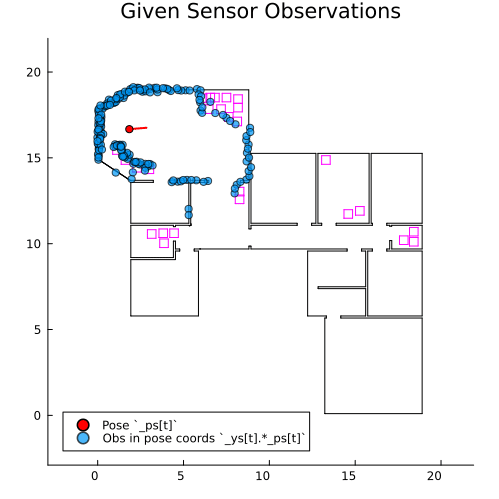

In [9]:
# -----------------------
ani = Animation()
for t=1:1:_T
    p = _ps[t]
    y = _ys[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Given Sensor Observations", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!(_boxes, c=:magenta, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(shuffle(y[1:2:end]).*p, c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)

### Perturbing the control data

The given data includes the accurate controls, so we'll add some noise ourselves. 

In [10]:
#nbx
function perturb(u::Control, x_noise, hd_noise)
    dx  = u.dx  + diagnormal([0.,0.], [x_noise, x_noise])
    dhd = u.dhd + normal(0, hd_noise)
    return Control(dx,dhd)
end

perturb (generic function with 1 method)

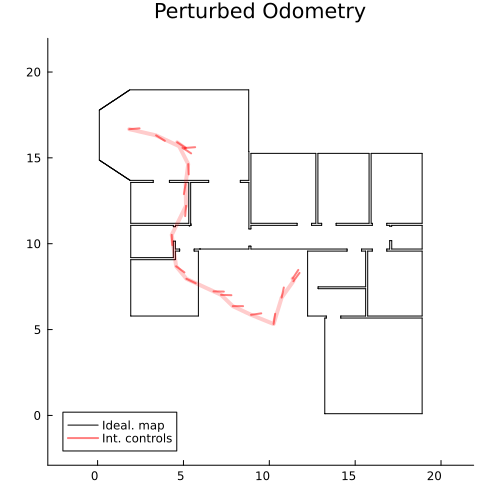

In [11]:
#nbx
x_noise  = 0.5
hd_noise = 5/360*2π
us_noisy = perturb.(_us, x_noise, hd_noise);

rel_ps = [p+u for (p,u) in zip(_ps[1:end-1],us_noisy)];
ps_noisy = [_ps[1]]
for u in us_noisy
    push!(ps_noisy, ps_noisy[end] + u)
end

# -----------------
env_plt = plot(
    size=(500,500), aspect_ratio=:equal, title="Perturbed Odometry", axis=true, grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!([p.x for p in ps_noisy], c=:red, label=nothing, alpha=0.2, linewidth=4)

plot!(ps_noisy[[1]],     c=:red,  r=.6, label="Int. controls", alpha=0.5, linewidth=2)
plot!(ps_noisy[2:end], c=:red,  r=.6,  label=nothing,  alpha=0.5, linewidth=2)
savefig("_imgs/loc_noisy_contr.png")
env_plt

Here we visualize the inputs the agent has access to in order to solve the task.

┌ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/loc_task_input.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/9Q9pN/src/animation.jl:156


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/loc_task_input.gif")
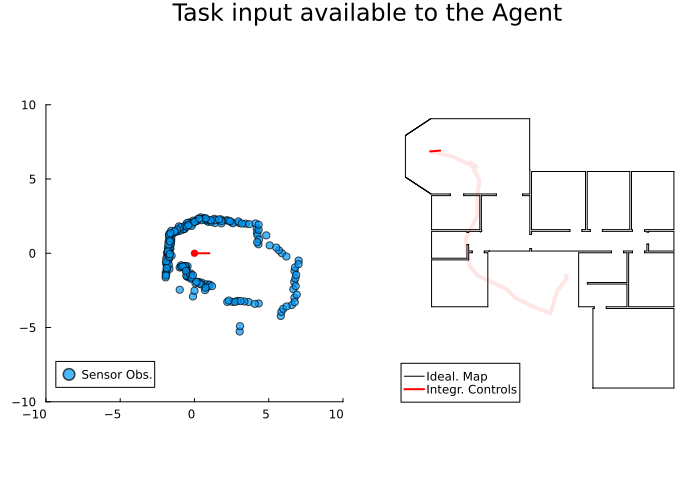

In [12]:
# -----------------------
myplts = []
ani = Animation()
for t=1:1:_T
    p = _ps[t]
    y = _ys[t]

    env_plt = plot(
        size=(300,300), aspect_ratio=:equal, axis=false, grid=false,
        xlim=(_bb[1][1]-1, _bb[2][1]+1),
        ylim=(_bb[1][2]-2, _bb[2][2]+2),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label="Ideal. Map")
    plot!([p.x for p in ps_noisy], c=:red, label=nothing, alpha=0.1, linewidth=4)
    plot!(ps_noisy[[t]], c=:red, r=.7,  label="Integr. Controls", linewidth=2)


    ego_plt = plot(
        size=(300,300), aspect_ratio=:equal, grid=false,
        xlim=(-10,10),
        ylim=(-10,10),
        legend=:bottomleft,
    )
    plot!([Pose()], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([zeros(2)], c=:red, markerstrokewidth=0, label=nothing)
    scatter!(shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Sensor Obs.")

    frame(ani, plot(ego_plt, env_plt, layout=grid(1, 2), size=(700,500), plot_title="Task input available to the Agent",  grid=false))
end
gif(ani, "_imgs/loc_task_input.gif", fps=2) # gif(ani, fname, fps=10)

## Key components of the model

(PLACEHOLDER) Graphical model of probabilistic SLAM:

```julia
     1        2        3                t        "model time"
     0        1        2                t-1      "chain time" (this will make sense in Part 2)

             u[1]     u[2]      ...    u[t-1]    "observed"
              |        |                 |        
    p[1] --- p[2] --- p[3] ---  ... --- p[t] 
     |        |        |                 |
    y[1]     y[2]     y[3]      ...     y[t]     "observed"
     |        |        |                 |
     m        m        m                 m       "observed" (in contrast to SLAM)
```



### Control Prior &mdash; $p(u)$

We don't use the prior at the moment. We assume the controls are given. But could be easily included in the model.

In [13]:
#nbx
"""
    u = control_prior_model(dx_noise=0.25, dhd_noise=45/360*2π)

Prior over what action the agent will take next.
"""
@gen function control_prior_model(dx_noise=0.25, dhd_noise=45/360*2π)
    dx  ~ diagnormal([0;0], [dx_noise, dx_noise])
    dhd ~ normal(0, dhd_noise)
    return Control(dx, dhd)
end;

### Pose-prior model

The pose prior has two different modes: 
we can either provide an initial guess for the starting pose and sample around it, or alternatively, sample uniformly from the bounding box that encompasses the environment.

In [14]:
#nbx
"""
    p = pose_prior_model(p::Union{Pose,Tuple}, x_noise=0.25, hd_noise=45.)

Takes a pose or a bounding box and returns a pose sampled from a prior.
"""
@gen function pose_prior_model(p::Union{Pose,Tuple}, x_noise=0.25, hd_noise=45/360*2π)
    # Todo: better signature would be to ask if p is pose or a bounding box
    if typeof(p) == Pose
        x  ~ diagnormal(p.x, [x_noise, x_noise])
        hd ~ normal(p.hd, hd_noise)
    else
        x  ~ mvuniform(p...)
        hd ~ uniform(0,2π)
    end

    return Pose(x, hd)
end;

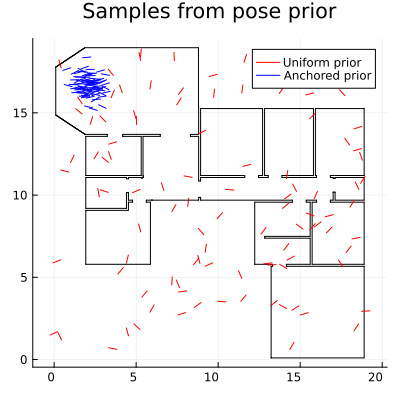

In [15]:
ps = [pose_prior_model(_bb) for t=1:100]
qs = [pose_prior_model(_ps[1], .5, 15/360*2π) for t=1:100]

# ----------------------
plot(size=(400,400), aspect_ratio=:equal, title="Samples from pose prior")
plot!(_segs, c=:black)
plot!(ps, c=:red,  label="Uniform prior")
plot!(qs, c=:blue, label="Anchored prior")

### Motion model

In [16]:
#nbx
"""
    q = motion_model(p, u, x_noise, hd_noise)

Sample a new pose `q` given the previous pose `p`, 
some control data `u = Control(dx, dhd)`, and noise levels
`x_noise` and `hd_noise`.
"""
@gen function motion_model(p, u, x_noise, hd_noise)
    dx, dhd = u.dx, u.dhd
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise)
    return Pose(x, hd)
end;

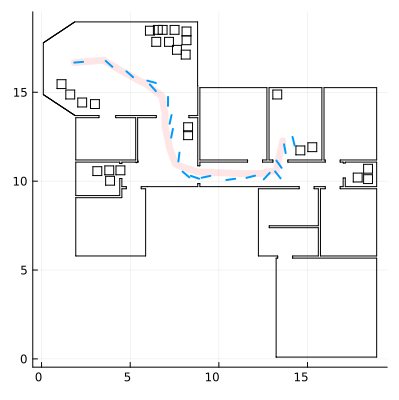

In [17]:
ps = Pose[_ps[1]]

for u in _us
    p = motion_model(ps[end], u, 1e-1, 2\pi * 1e-1)       
    push!(ps, p)
end
ps = [p for p in ps]

# ---------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black, linewidth=1)
plot!(_boxes, c=:black, linewidth=1)
plot!([p.x for p in _ps], c=:red, linewidth=7, alpha=0.1)
plot!(ps, c=col[1], linewidth=2)

### Sensor model

The sensor model will be based on
 - `cast` &mdash; a (CUDA accelerated) deterministic raycaster for point clouds, 
 - `get_2d_mixture_components` &mdash; a method to compute the 2dp3 mixture components, and
 - `sensodist_2dp3` &mdash; a (CUDA accelerated) sensor distribution implementing the 2dp3-likelihood.
  
By running the cell below we will include these methods; you can display more detailed description of each by calling `@doc` on them. We will then proceed by defining the sensor model.

Q: ADD EXPLANTION OF 3DP3 LIKELIHOOD HERE?

In [41]:
#nbx
include("src/sensor_distribution.jl")

#### Plug and play version

We initially construct the 2dp3 likelihood by combining predefined Gen distributions and types, providing flexibility and ease of implementation. However, this plug-and-play approach sacrifices runtime performance. To address this issue, we employ a custom Gen distribution for optimized performance.

In [24]:
gm             = HomogeneousMixture(diagnormal, [1, 1])
outlier_dist   = diagnormal
sensor_mix     = HeterogeneousMixture([gm, outlier_dist])
sensor_product = ProductDistribution(sensor_mix)

# Todo: Ideally I could wrap this distribution into a type that allows
#       for changes to the signature and replacing the logpdf.

# Creating the arguments is tedious, here's a helper that
# makes it less painful
function sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
    n,m, = size(ỹ)
    ỹ_perm = permutedims(ỹ, (1,3,2))
    args = (
        fill([1-outlier, outlier], n), 
        fill(1/m, n, m), 
        ỹ_perm, 
        fill(sig, n, 2,m), 
        fill(0.0, n,2), 
        fill(zmax, n,2)
    )
    return args
end

ỹ = rand(361, 21, 2)
sig         = 0.1
outlier     = 0.1
outlier_vol = 100.
zmax        = 100.
args = sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
x = sensor_product(args...)

@btime sensor_product($args...) samples=3 evals=3;
@btime logpdf($sensor_product, $x, $args...) samples=3 evals=3;

  2.697 ms (16870 allocations: 1.02 MiB)


  16.399 ms (161736 allocations: 5.66 MiB)


Runtimes of the plug-and-play sensor distribution `sensor_product`:
```julia
 2.909 ms (17940 allocations: 1.07 MiB)
17.092 ms (163181 allocations: 5.77 MiB)
```



In [25]:
@gen function sensor_model_v1(p, segs, w, sig, outlier, outlier_vol, zmax)
    p    = Vector(p)
    ps   = reshape(p, 1, 3)
    segs = stack(Vector.(segs))

    zs = cast(ps, segs; fov=_fov, num_a=_num_a)    
    ỹ  = get_2d_mixture_components(zs, _as, w)[1,:,:,:]
    ỹ   = ỹ

    args = sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
    x ~ sensor_product(args...)
    
    return x
end;

In [26]:
t = 7

p  = _ps[t]
the_map = _segs

w            = 5
s_noise      = 0.2
outlier      = 0.1
outliver_vol = 100.0
zmax         = 100.0

args  = (p, the_map, w, s_noise, outlier, outliver_vol, zmax)
tr = simulate(sensor_model_v1, args);
get_choices(tr)

│
└── :x : [[Inf, Inf], [Inf, Inf], [-4.951743877590461, -0.13757782916179612], [-110.67718100863095, 160.45653111868702], [-5.307690202629581, -0.7209443207685147], [-5.03110630933235, -0.8176821065060459], [-4.891212500697657, -0.6725068333232741], [-4.921104755036838, -0.7301175993960053], [-4.505700749828786, -1.2982310359230014], [-5.303918742710198, -1.0572688875658691], [-4.920047285599378, -0.9569052084394927], [-5.139617493100117, -0.35844958187018183], [-5.343229628547175, -0.7705114095031677], [-5.432316029737126, -1.0911489059048567], [-5.1392238005568105, -0.8034910700088311], [-5.031046336390103, -0.8378629405703265], [-5.19530504074457, -1.037721310466443], [-4.987018098955806, -1.7092421231251316], [-5.067289868300912, -1.91683192946318], [-5.2362567738454, -2.353565983259987], [-4.999609835836597, -1.3971765874752717], [-5.269228360008404, -2.9031677532217355], [-5.090293190790893, -2.759377515855312], [-5.382552108340836, -2.463279063816065], [-5.358036922652346, -1.8

In [27]:
x  = sensor_model_v1(args...)
ch = choicemap(:x => x)

@btime sensor_model_v1($args...)              samples=5 evals=5;
@btime simulate($sensor_model_v1, $args)      samples=5 evals=5;
@btime generate($sensor_model_v1, $args, $ch) samples=5 evals=5;

  2.832 ms (17940 allocations: 1.11 MiB)


  12.555 ms (111115 allocations: 4.31 MiB)


  10.272 ms (94243 allocations: 3.49 MiB)


Difference between `simulate` and `generate` comes from the additional sampling time. Both need to evaluate.

```julia
  2.441 ms (17352 allocations: 1.01 MiB)
  12.194 ms (110495 allocations: 4.20 MiB)
  10.197 ms (93567 allocations: 3.38 MiB)
```

#### Customized version

We now utilize the custom Gen distribution `sensordist_2dp3` for a more efficient implementation of the sensor model described above.
The distribution's signature looks as follows:
```julia
    x = sensordist_2dp3(ỹ, sig, outlier, outlier_vol=1.0)::Vector{Vector{Float64}}
```

In [44]:
#nbx
# This works on GPU only
@gen function sensor_model_GPU(p, segs, w, s_noise, outlier, outlier_vol, zmax=100.0)
    segs_ = CuArray(stack(Vector.(_segs)))
    p_    = CuArray(Vector(p))
    ps_   = reshape(p_, 1, 3)

    zs_      = cast_cu(ps_, segs_; fov=_fov)
    as_      = CuArray(_as)
    y_tilde_ = get_2d_mixture_components(zs_, as_, w)[1,:,:,:]

    x ~ sensordist_2dp3(y_tilde_, s_noise, outlier, outlier_vol)    
    return x
end;

In [45]:
#nbx
# This works on CPU
@gen function sensor_model_CPU(p, segs, w, s_noise, outlier, outlier_vol, zmax=100.0)
    ps   = reshape(Vector(p), 1, 3)
    zs   = cast(ps, stack(Vector.(segs)); fov=_fov, zmax=zmax)
    y_tilde = get_2d_mixture_components(zs, _as, w; fill_val_a=0.0)[1,:,:,:]

    x ~ sensordist_2dp3(y_tilde, s_noise, outlier, outlier_vol)    
    return x
end;


In [46]:
#nbx
if _cuda[]
    sensor_model = sensor_model_GPU
else
    sensor_model = sensor_model_CPU
end;

In [47]:
ỹ = rand(361, 21, 2)
sig         = 0.1
outlier     = 0.1
outlier_vol = 100.
zmax        = 100.


args = (ỹ, sig, outlier, outlier_vol) 
x = sensordist_2dp3(args...)

@btime sensordist_2dp3($args...)              samples=3 evals=3;
@btime logpdf($sensordist_2dp3, $x, $args...) samples=3 evals=3;

  76.261 μs (1010 allocations: 86.05 KiB)


  715.329 μs (81 allocations: 561.09 KiB)


In [48]:
t = 7

p  = _ps[t]
m  = _segs

w            = 5
s_noise      = 0.2
outlier      = 0.1
outlier_vol = 100.0
zmax = 100.0

args  = (p, m, w, s_noise, outlier, outlier_vol, zmax)
x  = sensor_model(args...)
ch = choicemap(:x => x)

@btime sensor_model($args...)              samples=5 evals=5;
@btime simulate($sensor_model, $args)      samples=5 evals=5;
@btime generate($sensor_model, $args, $ch) samples=5 evals=5;

  12.610 ms (17732 allocations: 869.35 KiB)


  13.046 ms (18207 allocations: 917.80 KiB)


  1.148 ms (1744 allocations: 152.47 KiB)


Difference between `simulate` and `generate` comes from the additional sampling time. Both need to evaluate.

```julia
  12.123 ms (17611 allocations: 864.49 KiB)
  12.556 ms (18097 allocations: 913.45 KiB)
  1.074 ms (1714 allocations: 152.14 KiB)
```

  12.746 ms (17666 allocations: 866.38 KiB)


  13.027 ms (18038 allocations: 910.22 KiB)


  1.168 ms (1759 allocations: 153.33 KiB)


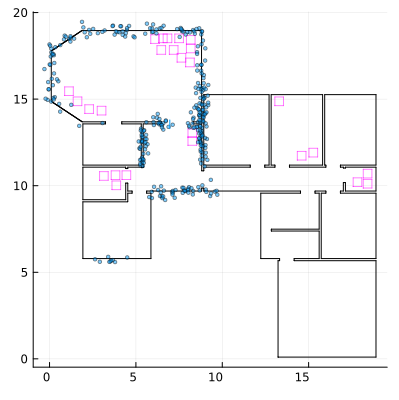

In [50]:
t = 7

p  = _ps[t]

sensor_args = (
    w            = 5,
    s_noise      = 0.2,
    outlier      = 0.1,
    outliver_vol = 100.0,
)

args  = (p, _segs, sensor_args...)
tr = simulate(sensor_model, args)
x = tr[]

ch = choicemap(:x => x)

@btime sensor_model(args...)            samples=3 evals=3;
@btime simulate(sensor_model, args)     samples=3 evals=3;
@btime generate(sensor_model, args, ch) samples=5 evals=5;

# -------------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(_boxes, c=:magenta, alpha=0.5)
scatter!(x.*_ps[t], c=col[1], alpha=0.5, markersize=2)
plot!(_ps[t], c=col[1])

#### Explicit data model

TODO: Add text and explanations

In [45]:
gm = HomogeneousMixture(diagnormal, [1, 1])

HomogeneousMixture{Vector{Float64}}(GenDistributionZoo.DiagonalNormal(), [1, 1])

In [46]:
@gen function data_outlier_model(ỹ, sig, outlier, zmax)    
    m = size(ỹ,1)

    outlier ~ bernoulli(outlier)
    if outlier
        x ~ diagnormal([0.;0.],[zmax;zmax])
    else
        x ~ gm(fill(1/m, m), ỹ', fill(sig, 2, m))
    end  
    
    return x, outlier
end;

mapped_data_model = Gen.Map(data_outlier_model);

In [47]:
ỹ = rand(10, 3, 2)
sig         = 0.1
outlier     = 0.1
zmax        = 100.

n,m, = size(ỹ)
args = map(a->fill(a, n), (sig, outlier, zmax))
args = (selectdim.([ỹ], [1], 1:n), args...)

tr = simulate(mapped_data_model, args);
display(get_choices(tr))
tr[][1]

│
├── 1
│   │
│   ├── :outlier : true
│   │
│   └── :x : [33.12860021412016, -17.03911529636352]
│
├── 2
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.7416254670800587, 0.1806635904227719]
│
├── 3
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.3688937837962501, 0.7303668626237214]
│
├── 4
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.107886493361602, 0.8546750100499952]
│
├── 5
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.9335798145388285, 0.21198802591891325]
│
├── 6
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.5489170801091315, 0.46625910429678674]
│
├── 7
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.29517904866108413, 0.5591067571998084]
│
├── 8
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.7958945392247264, 0.2031828082159961]
│
├── 9
│   │
│   ├── :outlier : false
│   │
│   └── :x : [0.37066898548750105, 0.045097249181521915]
│
└── 10
    │
    ├── :outlier : false
    │
    └── :x : [0.02720585686648438, 1.0381780800331692]


([33.12860021412016, -17.03911529636352], true)

In [43]:
@btime simulate(mapped_data_model, args)     samples=3 evals=3;
@btime generate(mapped_data_model, args, ch) samples=3 evals=3;

  119.022 μs (1200 allocations: 61.67 KiB)


  137.275 μs (1210 allocations: 61.98 KiB)


In [48]:
@gen function sensor_model_with_outliers(p, segs, w, sig, outlier, outlier_vol, zmax)
    ps = reshape(Vector(p), 1, 3)

    # p_    = CuArray(Vector(p))
    # ps_   = reshape(p_, 1, 3)

    segs = stack(Vector.(segs))
    # as_   = CuArray(_as) 

    zs = cast(ps, segs; fov=_fov, num_a=_num_a)    
    ỹ  = get_2d_mixture_components(zs, _as, w)[1,:,:,:]
    # ỹ   = Array(ỹ_)

    n,m, = size(ỹ)
    args = map(a->fill(a, n), (sig, outlier, zmax))
    args = (selectdim.([ỹ], [1], 1:n), args...)
    data ~ mapped_data_model(args...);

    return data
end;

In [49]:
t = 7

p  = _ps[t]

sensor_args = (
    w            = 10,
    s_noise      = 0.1,
    outlier      = 0.1,
    outliver_vol = 10.0,
    zmax = 100.0,
)

args  = (p, _segs, sensor_args...)
sensor_model_with_outliers(args...)

tr = simulate(sensor_model_with_outliers, args);

In [50]:
@gen function outlier_proposal(tr,i)
    {:data => i => :outlier} ~ bernoulli(0.5)
end;

┌ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/loc_outlier_MH_ani.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/9Q9pN/src/animation.jl:156


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/loc_outlier_MH_ani.gif")
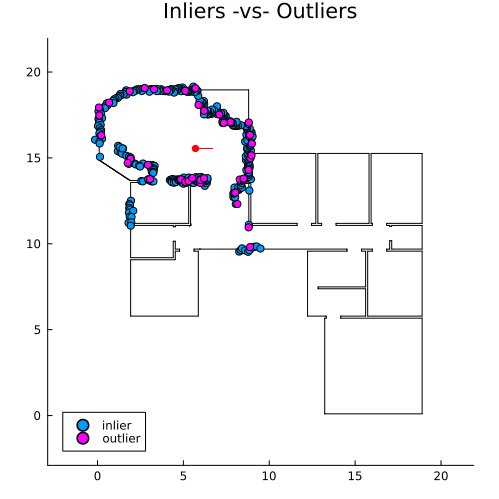

In [58]:
t = 4

p  = _ps[t]

sensor_args = (
    w            = 10,
    s_noise      = 0.1,
    outlier      = 0.1,
    outliver_vol = 10.0,
    zmax = 100.0,
)

args  = (p, _segs, sensor_args...)
sensor_model_with_outliers(args...)

ch = choicemap()
for i=1:_num_a
    ch[:data => i => :x] = _ys[t][i]
end

tr, w = generate(sensor_model_with_outliers, args, ch)


# -------------------------------
ani = Animation()
for k=1:7
    if k>1
        for i=1:_num_a
            tr,acc = mh(tr, outlier_proposal, (i,))
        end
    end
    data = tr[]
    x   = [d[1] for d in data]
    out = [d[2] for d in data]
    
    mypl = plot(size=(500,500), aspect_ratio=:equal, title="Inliers -vs- Outliers", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black)
    scatter!(x[map(b->!b,out)].*_ps[t], c=col[1], alpha=1., markersize=4, label="inlier")
    scatter!(x[out].*_ps[t], c=:magenta, alpha=1., markersize=4, label="outlier")
    scatter!(_ps[t], c=:red)

    frame(ani, mypl) 
end
gif(ani, "_imgs/loc_outlier_MH_ani.gif", fps=3)

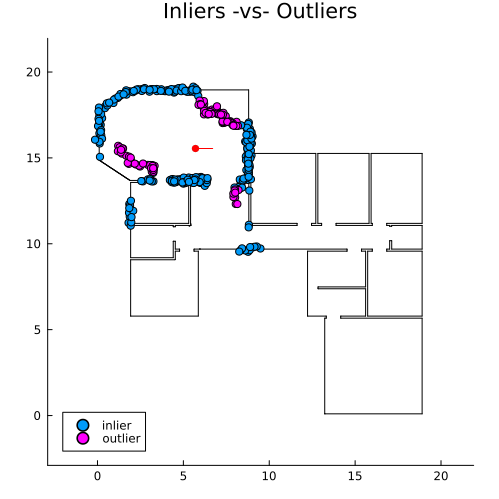

In [60]:
tr′, = Gen.update(tr, choicemap([(:data => i => :outlier) => true for i=1:_num_a]...))
w1 = Gen.project.([tr′], [select(:data => i => :x) for i=1:_num_a])

tr′, = Gen.update(tr, choicemap([(:data => i => :outlier) => false for i=1:_num_a]...))
w2 = Gen.project.([tr′], [select(:data => i => :x) for i=1:_num_a])


out = w1 .> w2;

# -------------------------------
plot(size=(500,500), aspect_ratio=:equal, title="Inliers -vs- Outliers", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black)
scatter!(shuffle(x[map(b->!b,out)]).*_ps[t], c=col[1], alpha=1., markersize=4, label="inlier")
scatter!(shuffle(x[out]).*_ps[t], c=:magenta, alpha=1., markersize=4, label="outlier")
scatter!(_ps[t], c=:red)

┌ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/loc_outlier_ani.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/9Q9pN/src/animation.jl:156


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/loc_outlier_ani.gif")
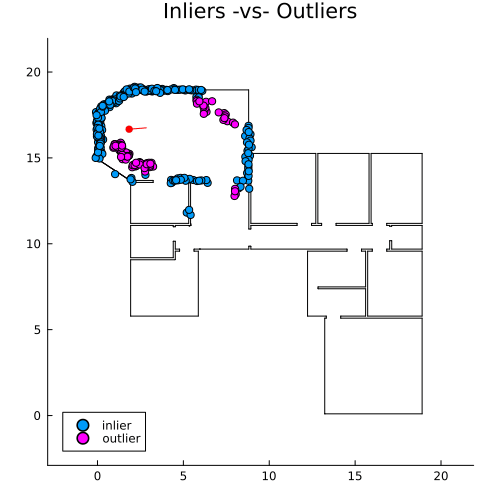

In [55]:
# -----------------------
ani = Animation()
for t=1:1:_T
    p  = _ps[t]

    sensor_args = (
        w            = 10,
        s_noise      = 0.1,
        outlier      = 0.1,
        outliver_vol = 10.0,
        zmax = 100.0,
    )

    args  = (p, _segs, sensor_args...)
    sensor_model_with_outliers(args...)

    ch = choicemap()
    for i=1:_num_a
        ch[:data => i => :x] = _ys[t][i]
    end

    tr, w = generate(sensor_model_with_outliers, args, ch)
    data = tr[]
    x = [d[1] for d in data]

    tr′, = Gen.update(tr, choicemap([(:data => i => :outlier) => true for i=1:_num_a]...))
    w1 = Gen.project.([tr′], [select(:data => i => :x) for i=1:_num_a])
    
    tr′, = Gen.update(tr, choicemap([(:data => i => :outlier) => false for i=1:_num_a]...))
    w2 = Gen.project.([tr′], [select(:data => i => :x) for i=1:_num_a])
    
    
    out = w1 .> w2;
    
    # -------------------------------
    mypl = plot(size=(500,500), aspect_ratio=:equal, title="Inliers -vs- Outliers", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black)
    scatter!(shuffle(x[map(b->!b,out)]).*_ps[t], c=col[1], alpha=1., markersize=4, label="inlier")
    scatter!(shuffle(x[out]).*_ps[t], c=:magenta, alpha=1., markersize=4, label="outlier")
    scatter!(_ps[t], c=:red)

    frame(ani, mypl)
end
gif(ani, "_imgs/loc_outlier_ani.gif", fps=4)